### Importing the necessary libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
#from tensorflow.keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D


#from keras.utils import plot_model


print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.5.0


In [3]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet_v2 import ResNet152V2

In [4]:
from tqdm import tqdm
import cv2
import re
from tensorflow.keras.layers import MaxPooling2D

### Data Pre-Processing

In [91]:
'''
base_dir = "E:/ventricle/ventrical_image/1Yr_1.5T/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))
'''

'\nbase_dir = "E:/ventricle/ventrical_image/1Yr_1.5T/"\nroot_dir = "./"\ntest_dir = base_dir + "test/"\ntrain_dir = base_dir + "train/"\nwork_dir = root_dir + "dataset/"\n\nif os.path.exists(work_dir):\n    remove_tree(work_dir)\n    \n\nos.mkdir(work_dir)\ncopy_tree(train_dir, work_dir)\ncopy_tree(test_dir, work_dir)\nprint("Working Directory Contents:", os.listdir(work_dir))\n'

In [4]:
WORK_DIR = './dataset/'

CLASSES = [ 'CN','MCI','AD']

IMG_SIZE = 128
IMAGE_SIZE = [128, 128]
DIM = (IMG_SIZE, IMG_SIZE)

### Make DataFrame

In [5]:
images = [[] for i in range(6518)]  #6518
labels = [[] for i in range(6518)]
for subfolder in tqdm(os.listdir("E:/dataset_nocrop")):
    subfolder_path = os.path.join("E:/dataset_nocrop", subfolder)  #AD CN MCI folder
    for folder in os.listdir(subfolder_path):    #0,1,2....,2294
        subfolder_path2=os.path.join(subfolder_path,folder)   
        for image_filename in os.listdir(subfolder_path2):    #ex :0的所有切片圖
            image_path = os.path.join(subfolder_path2, image_filename)
            images[int(folder)].append(image_path)
        labels[int(folder)].append(subfolder)
df = pd.DataFrame({'image': images, 'label': labels})
df

100%|██████████| 3/3 [01:04<00:00, 21.55s/it]


,image,label
0,"[E:/dataset_nocrop\CN\0\slide_0_0.jpg, E:/data...",[CN]
1,"[E:/dataset_nocrop\CN\1\slide_1_0.jpg, E:/data...",[CN]
2,"[E:/dataset_nocrop\CN\2\slide_2_0.jpg, E:/data...",[CN]
3,"[E:/dataset_nocrop\CN\3\slide_3_0.jpg, E:/data...",[CN]
4,"[E:/dataset_nocrop\CN\4\slide_4_0.jpg, E:/data...",[CN]
...,...,...
6513,"[E:/dataset_nocrop\CN\6513\slide_6513_0.jpg, E...",[CN]
6514,"[E:/dataset_nocrop\CN\6514\slide_6514_0.jpg, E...",[CN]
6515,"[E:/dataset_nocrop\CN\6515\slide_6515_0.jpg, E...",[CN]
6516,"[E:/dataset_nocrop\CN\6516\slide_6516_0.jpg, E...",[CN]


In [6]:
# 刪除前 4336 筆資料
df = df.iloc[4336:]

# 重置索引
df = df.reset_index(drop=True)
# 顯示處理後的 DataFrame
print(df)

                                                  image label
0     [E:/dataset_nocrop\CN\4336\slide_4336_0.jpg, E...  [CN]
1     [E:/dataset_nocrop\CN\4337\slide_4337_0.jpg, E...  [CN]
2     [E:/dataset_nocrop\CN\4338\slide_4338_0.jpg, E...  [CN]
3     [E:/dataset_nocrop\CN\4339\slide_4339_0.jpg, E...  [CN]
4     [E:/dataset_nocrop\CN\4340\slide_4340_0.jpg, E...  [CN]
...                                                 ...   ...
2177  [E:/dataset_nocrop\CN\6513\slide_6513_0.jpg, E...  [CN]
2178  [E:/dataset_nocrop\CN\6514\slide_6514_0.jpg, E...  [CN]
2179  [E:/dataset_nocrop\CN\6515\slide_6515_0.jpg, E...  [CN]
2180  [E:/dataset_nocrop\CN\6516\slide_6516_0.jpg, E...  [CN]
2181  [E:/dataset_nocrop\CN\6517\slide_6517_0.jpg, E...  [CN]

[2182 rows x 2 columns]


In [8]:
df['label'][500]

['MCI']

### 去掉label的list

In [9]:
for ind , label in enumerate(df['label']):
    df['label'][ind] = label[0]


df


,image,label
0,"[E:/dataset_nocrop\CN\4336\slide_4336_0.jpg, E...",CN
1,"[E:/dataset_nocrop\CN\4337\slide_4337_0.jpg, E...",CN
2,"[E:/dataset_nocrop\CN\4338\slide_4338_0.jpg, E...",CN
3,"[E:/dataset_nocrop\CN\4339\slide_4339_0.jpg, E...",CN
4,"[E:/dataset_nocrop\CN\4340\slide_4340_0.jpg, E...",CN
...,...,...
2177,"[E:/dataset_nocrop\CN\6513\slide_6513_0.jpg, E...",CN
2178,"[E:/dataset_nocrop\CN\6514\slide_6514_0.jpg, E...",CN
2179,"[E:/dataset_nocrop\CN\6515\slide_6515_0.jpg, E...",CN
2180,"[E:/dataset_nocrop\CN\6516\slide_6516_0.jpg, E...",CN


### !!!!!!!!!!!!

In [10]:
for i in range(1001,6518):
    df = df.drop(i)

In [11]:
df

,image,label
0,"[E:/dataset_nocrop\CN\0\slide_0_0.jpg, E:/data...",CN
1,"[E:/dataset_nocrop\CN\1\slide_1_0.jpg, E:/data...",CN
2,"[E:/dataset_nocrop\CN\2\slide_2_0.jpg, E:/data...",CN
3,"[E:/dataset_nocrop\CN\3\slide_3_0.jpg, E:/data...",CN
4,"[E:/dataset_nocrop\CN\4\slide_4_0.jpg, E:/data...",CN
...,...,...
996,"[E:/dataset_nocrop\MCI\996\slide_996_0.jpg, E:...",MCI
997,"[E:/dataset_nocrop\MCI\997\slide_997_0.jpg, E:...",MCI
998,"[E:/dataset_nocrop\MCI\998\slide_998_0.jpg, E:...",MCI
999,"[E:/dataset_nocrop\MCI\999\slide_999_0.jpg, E:...",MCI


### !!!!!!!!!!!!!!

305 484 212


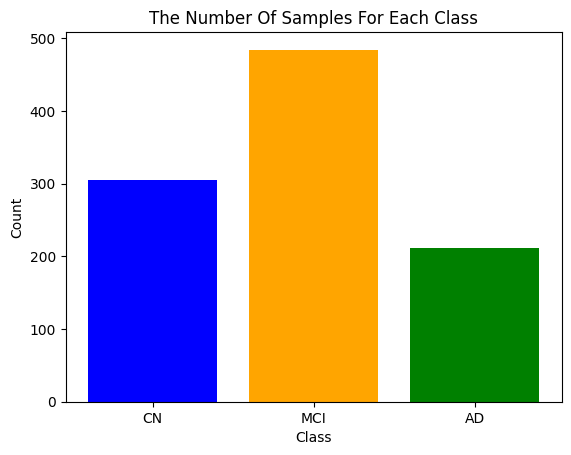

In [12]:
# 使用 value_counts() 獲取各類標籤的計數
counts = df['label'][:].value_counts()

# 從 counts 中獲取 'CN' 和 'MCI' 的計數，如果不存在則返回0
a = counts.get('CN', 0)
b = counts.get('MCI', 0)
c = counts.get('AD', 0)  # 如果你只關心 'CN', 'MCI' 和 'Other'

# 如果你想計算不是 'CN' 或 'MCI' 的所有其他類別
# 你可以將所有值加起來，然後減去 'CN' 和 'MCI' 的總和
#c = counts.sum() - (a + b)

# 輸出結果
print(a, b, c)
labels = ['CN', 'MCI', 'AD']
counts = [a, b, c]

# 使用条形图展示计数
plt.bar(labels, counts, color=['blue', 'orange', 'green'])

# 添加标题和轴标签
plt.title('The Number Of Samples For Each Class')
plt.xlabel('Class')
plt.ylabel('Count')

# 显示图表
plt.show()

### 視覺化

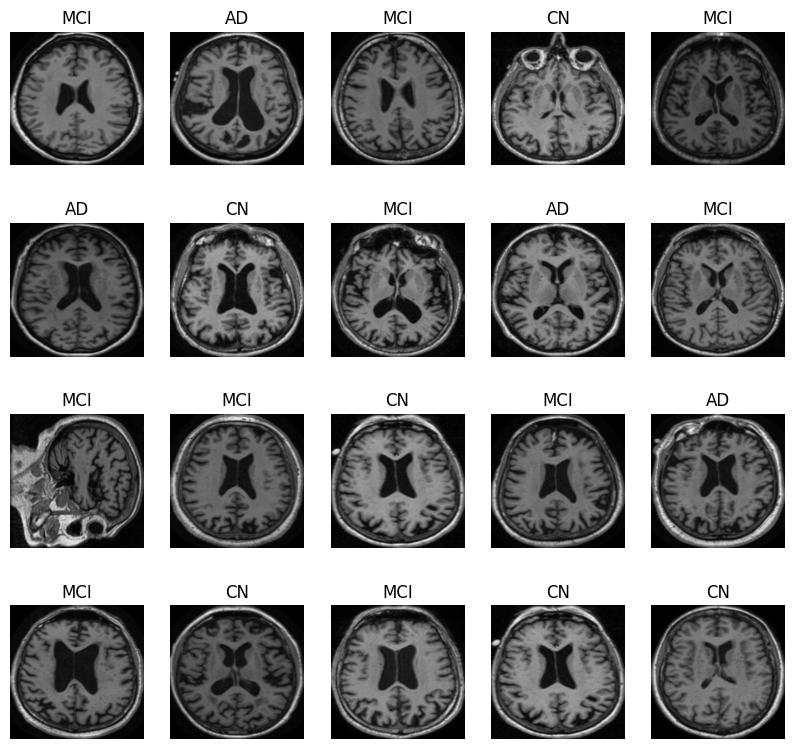

In [8]:
plt.figure(figsize=(10,12))
for n,i in enumerate(np.random.randint(0,len(df),20)):
    plt.subplot(5,5,n+1)
    img=cv2.imread(df.image[i][20])
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i],fontsize=12)

### 排序切片

In [19]:
for ind , data in enumerate(df['image']):
# 排序函數，用正則表達式從每個路徑中提取數字並按該數字排序
    #df['image'][ind] = sorted(data, key=lambda x: int(re.search(r"slide_{}_(\d+)\.jpg".format(ind), x).group(1)))
    df['image'][ind] = sorted(data, key=lambda x: int(re.search(r"\d+(?=\.\w+$)", x).group()))

# # 輸出排序後的列表
# for path in sorted_paths:
#     print(path)

### 把多張切片取20張，疊在一起  (改成取三張 0.65 0.7 0.75)

In [10]:
cv2.imread(df['image'][0][0])

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [11]:
for i in df['image']:
    print(len(i))

48
45
46
48
45
48
43
45
48
43
43
48
43
47
49
49
48
49
49
46
45
49
50
49
48
50
50
49
48
50
45
48
48
45
48
48
45
46
46
45
46
48
46
47
46
45
45
45
48
47
47
45
46
49
49
46
36
35
36
36
35
37
34
33
33
35
35
33
35
34
32
45
50
41
49
43
40
41
49
42
44
41
40
45
41
45
47
42
43
45
41
42
49
43
43
41
46
42
49
41
41
41
39
41
41
39
39
47
47
47
46
46
46
44
46
47
46
45
44
45
49
44
44
45
46
49
47
49
49
47
43
43
45
47
45
42
44
42
44
45
45
47
48
45
47
47
42
45
47
47
44
42
47
44
50
47
47
47
46
46
46
46
49
51
48
49
43
43
45
47
46
44
49
46
45
48
45
50
48
48
46
47
48
48
46
50
46
45
48
48
47
46
46
48
46
48
46
49
49
49
49
49
46
49
44
46
49
49
46
50
49
39
40
49
39
47
44
46
47
50
49
50
50
35
34
37
36
34
36
32
33
34
33
34
35
35
35
35
33
35
35
35
35
35
34
34
34
35
37
34
36
35
34
34
34
36
32
35
34
36
33
35
37
35
35
34
34
36
34
33
34
33
34
35
48
47
48
48
47
48
46
49
46
46
49
46
47
47
48
48
48
48
46
49
48
46
49
48
46
45
46
46
45
46
46
46
47
46
46
47
49
46
47
49
47
47
47
47
47
47
47
48
47
47
47
47
46
47
47
47
46
45
47
4

In [12]:
# stack_images = [[] for i in range(len(df['image']))]
# for ind, data in enumerate(df['image']):
#     center = int(len(data) * 0.5)
#     for slice_ind ,slice in enumerate(data):
#         if center-5 < slice_ind <= center+15:
#             a = cv2.imread(slice)
#             gray_image = cv2.cvtColor(a, cv2.COLOR_BGR2GRAY)
#             img_tensor = tf.convert_to_tensor(gray_image ,dtype=tf.uint8)

#             stack_images[ind].append(img_tensor)
#         df['image'][ind] = tf.stack(stack_images[ind])
#     #print(ind)

In [12]:
# #取三張的CODE
# stack_images = [[] for i in range(len(df['image']))]
# for ind, data in enumerate(df['image']):
    
#     for slice_ind ,slice in enumerate(data):
#         if slice_ind == int(len(data) * 0.5) or slice_ind == int(len(data) * 0.7) or slice_ind == int(len(data) * 0.9):
#             a = cv2.imread(slice)
#             gray_image = cv2.cvtColor(a, cv2.COLOR_BGR2GRAY)
#             img_tensor = tf.convert_to_tensor(gray_image ,dtype=tf.uint8)

#             stack_images[ind].append(img_tensor)
#         df['image'][ind] = tf.stack(stack_images[ind])
#     #print(ind)

TypeError: Image data of dtype <U43 cannot be converted to float

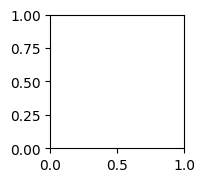

In [13]:
plt.figure(figsize=(10,12))
for n,i in enumerate(np.random.randint(0,len(df),20)):
    plt.subplot(5,5,n+1)
    img=df['image'][i][1]
    #print(img.shape)
    #img=cv2.resize(img,(224,224))
    #img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img,cmap = 'gray')
    plt.axis('off')
    plt.title(df.label[i]+str(i),fontsize=12)

In [17]:
if not os.path.exists('stack_images_nocrop_slides'):
        os.makedirs('stack_images_nocrop_slides')

In [19]:

# for idx, tensor in enumerate(df['image']):
#     #if idx >2293:
#     if tensor is not None:
#         np.save(f'./stack_images_nocrop_slides/image_stack_{idx}.npy', tensor.numpy())
#     else:
#         print(f"Notice: No data to save for index {idx}.")
        

In [82]:
# for i in range(len(df['image'])):
#     df['image'][i] = os.path.join('./stack_images' + '/image_stack_{}.npy'.format(i) )

In [83]:
#df 

,image,label
0,./stack_images/image_stack_0.npy,[CN]
1,./stack_images/image_stack_1.npy,[CN]
2,./stack_images/image_stack_2.npy,[CN]
3,./stack_images/image_stack_3.npy,[CN]
4,./stack_images/image_stack_4.npy,[CN]
...,...,...
2289,./stack_images/image_stack_2289.npy,[CN]
2290,./stack_images/image_stack_2290.npy,[CN]
2291,./stack_images/image_stack_2291.npy,[MCI]
2292,./stack_images/image_stack_2292.npy,[MCI]


In [14]:
type(df['image'][0])

list

In [20]:
stack_array = []
path = "E:\stack_images_slides20_shape_20_256_256"
for ind , data in enumerate(os.listdir(path)):
    #if ind <1001:
    path2 = os.path.join( "E:\stack_images_slides20_shape_20_256_256" ,  data)
    
    array = np.load(path2)

    stack_array.append(array)

In [21]:
num=[]
for ind , arr in enumerate(stack_array):
    if arr.shape[0] != 10:
        num.append(ind)
print(len(num))

2182


In [22]:
stack_array[579][0].max()

253

### Normalize

In [23]:
for ind , data in enumerate(stack_array):
    stack_array[ind] = data / data.max()


### Reshape / permute

In [24]:
for ind , array in enumerate(stack_array):  #擴充維度變成 (20,128,128,1)

    stack_array[ind] = np.expand_dims(array, axis=-1)

In [25]:
stack_array[0].shape

(20, 256, 256, 1)

In [17]:
# for ind , array in enumerate(stack_array):

#     stack_array[ind] = np.array(tf.transpose(array,perm=[1,2,0]))

In [26]:
len(stack_array)

2182

In [14]:
#stack_array = np.array(stack_array, dtype=object)

In [15]:
#stack_array.shape

(1001, 10, 256, 256, 1)

### !!!!!!!!!!!!!!不清楚的影向

### !!!!!!!!!!!!!!!!!

In [27]:
labels2=[]
for i in df['label']:
    labels2.append(i)

In [28]:
len(labels2)

2182

In [29]:


# 标签到数字的映射字典
label_map = {'CN': [1,0,0], 'MCI': [0,1,0], 'AD': [0,0,1]}

# 将标签列表替换为数字
labels_as_numbers = [np.array(label_map[label]) for label in labels2]

print(len(labels_as_numbers))

2182


In [30]:
train_dataset = stack_array

#test_examples = stack_array[1835:]
#test_labels = labels_as_numbers[1835:]

In [31]:
train_labels_dataset = labels_as_numbers

In [32]:
train_labels_dataset[0].shape

(3,)

In [ ]:
# for ind , array in enumerate(train_labels_dataset):
#     train_labels_dataset[ind] = np.array(tf.transpose(array , perm=[0]))

In [33]:
# for ind , array in enumerate(train_labels_dataset):
#     train_labels_dataset[ind] = np.array(tf.reshape(array , (3,)))

In [33]:
train_labels_dataset[0].shape

(3,)

In [34]:
train_dataset = list(train_dataset)
train_labels_dataset = list(train_labels_dataset)

In [35]:
train_dataset = tf.convert_to_tensor(train_dataset)
train_labels_dataset = tf.convert_to_tensor(train_labels_dataset)

In [36]:
train_dataset.shape

TensorShape([2182, 20, 256, 256, 1])

In [37]:
train_labels_dataset.shape

TensorShape([2182, 3])

### !!!!!!!!!!!!!!!

### !!!!!!!!!!!!!!!

In [38]:
#Performing Image Augmentation to have more data samples

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255)

#train_data_gen = work_dr.flow_from_dataframe(df,x_col='image',y_col='label', target_size=(128,128), batch_size=6500, shuffle=False,validate_filenames=False)

### !!!!!!!!!!!!!!!!!!!!!!!!

In [ ]:


### Goal :: 把一樣的 train_data_gen.filenames[0].split('_')[1] concate在一起 
### 再用 train_data_gen.filenames[0].split('_')[2].split('.')[0] 由小到大排列
### 變成新的形態

### ex : first data shape == (128 ,128 , 40 * 3)  or  (40 , 128 , 128 ,3)


### 若是前者  把 (128, 128 , 120 ) 用1 * 1 * n 的捲基層 進行降維， 降成(128,128,3)再輸入進 pretrained model

In [90]:


# 假设你有一个包含文件路径的列表 file_list


# # 读取每个图像并将其转换为张量
# image_tensors = []
# for file_path in train_data_gen.filenames:
#     # 使用 Pillow 库加载图像
#     img = Image.open('./dataset/' + file_path)
#     # 将图像转换为 TensorFlow 张量，并调整大小为 (128, 128, 3)
#     img_tensor = tf.convert_to_tensor(img, dtype=tf.float32) / 255.0  # 将像素值缩放到 [0, 1]
#     #img_tensor = tf.image.resize(img_tensor, (128, 128))
#     # 添加到图像张量列表中
#     image_tensors.append(img_tensor)

# # 使用 tf.stack 函数将图像张量叠加成一个张量
# stacked_images = tf.stack(image_tensors)

# # 现在 stacked_images 就是一个形状为 (30, 128, 128, 3) 的张量，
# # 包含了所有图像叠加在一起的数据


In [91]:

# # 使用 next 來獲取生成器的下一個元素，即第一批次的數據
# data_batch = next(train_data_gen)

# # data_batch 是一個元組，包含了圖像數據和標籤
# # data_batch[0] 是圖像數據，data_batch[1] 是對應的標籤
# images, labels = data_batch

# filename = train_data_gen.filenames

# # 查看第一筆圖像數據
# first_image = images[0]
# print("Shape of the first image:", first_image.shape)

# # 如果你想看圖像數據的具體內容，可以打印它
# print("Array of the first image:", first_image)

# print('label:', labels[0])


### !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

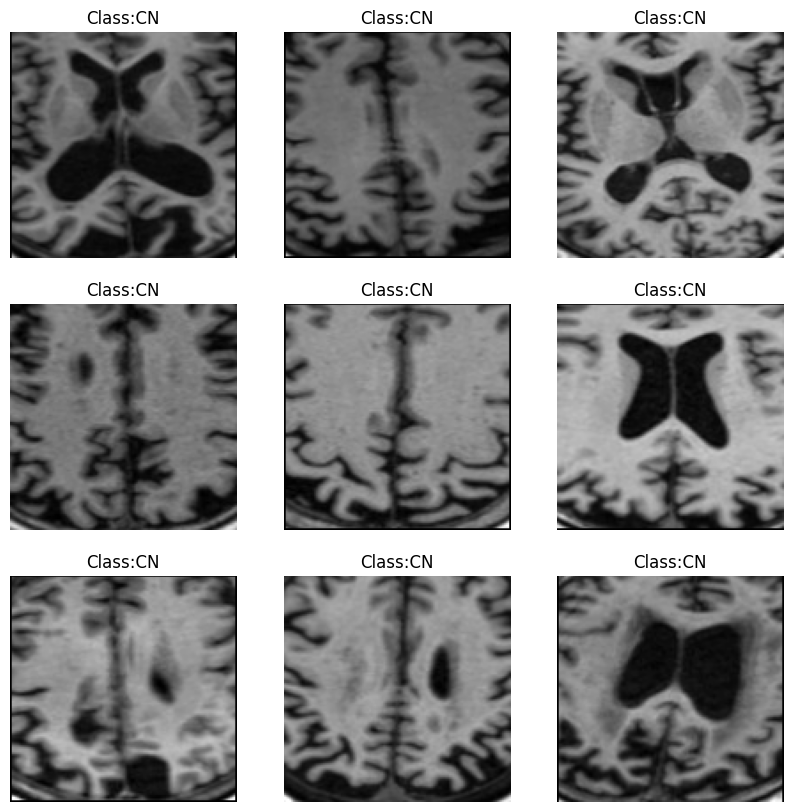

In [10]:
# def show_images(generator,y_pred=None):
#     """
#     Input: An image generator,predicted labels (optional)
#     Output: Displays a grid of 9 images with lables
#     """
    
#     # get image lables
#     labels =dict(zip([0,1,2], CLASSES))
    
#     # get a batch of images
#     x,y = generator.next()
    
#     # display a grid of 9 images
#     plt.figure(figsize=(10, 10))
#     if y_pred is None:
#         for i in range(9):
#             ax = plt.subplot(3, 3, i + 1)
#             idx = randint(0, 6400)
#             plt.imshow(x[idx])
#             plt.axis("off")
#             plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
#     else:
#         for i in range(9):
#             ax = plt.subplot(3, 3, i + 1)
#             plt.imshow(x[i])
#             plt.axis("off")
#             plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# # Display Train Images
# show_images(train_data_gen)

In [95]:
# #Performing over-sampling of the data, since the classes are imbalanced

# sm = SMOTE(random_state=42)

# train_data, train_labels = sm.fit_resample(train_dataset.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels_dataset)

# train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

# print(train_data.shape, train_labels.shape)

### !!!!

In [43]:

# minus_channels = Sequential([
#     Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 60),padding = 'same'),
    
#     Conv2D(16, (3, 3), activation='relu',padding = 'same'),
    
#     Conv2D(8, (3, 3), activation='relu',padding = 'same'),
    
#     Conv2D(3,(3,3), activation = 'relu',padding = 'same')
# ])


# minus_channels.summary() 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_98 (Conv2D)          (None, 128, 128, 32)      17312     
                                                                 
 conv2d_99 (Conv2D)          (None, 128, 128, 16)      4624      
                                                                 
 conv2d_100 (Conv2D)         (None, 128, 128, 8)       1160      
                                                                 
 conv2d_101 (Conv2D)         (None, 128, 128, 3)       219       
                                                                 
Total params: 23315 (91.07 KB)
Trainable params: 23315 (91.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [39]:
train_labels_dataset[1]

: 

In [1]:
train_dataset.shape

NameError: name 'train_dataset' is not defined

In [45]:
p = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
a=0
b=0
c=0
for i in train_labels_dataset:
    if i[0] == 1:
        a+=1
    elif i[1] == 1:
        b+=1
    else:
        c+=1
print(a,b,c)

2004 3279 1190


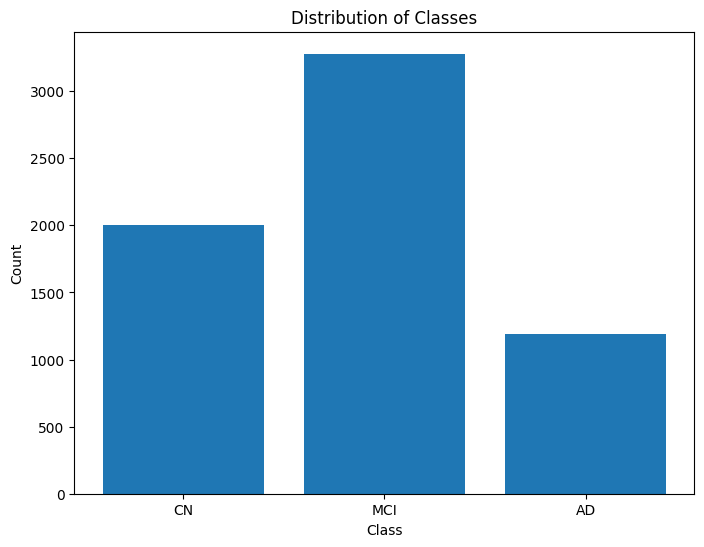

In [46]:

# 計算每個類別的樣本數量
p = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
count = [0,0,0]
class_names = ['CN', 'MCI', 'AD']
class_counts = [a, b ,c]

# 視覺化
plt.figure(figsize=(8, 6))
plt.bar(class_names, class_counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Classes')
plt.show()

In [41]:
#Performing over-sampling of the data, since the classes are imbalanced

import imblearn
smote = imblearn.over_sampling.SMOTE(random_state=42)
train_data, train_labels = smote.fit_resample(train_dataset.reshape(-1, 256 * 256 * 3), train_labels_dataset)
train_data = train_data.reshape(-1, 256,256, 3)
print(train_data.shape, train_labels.shape)



(6957, 256, 256, 3) (6957, 3)


In [47]:
# data_augmentation = tf.keras.Sequential([
#     tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
#     tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
# ])

# # 将数据增强应用于每个样本
# augmented_train_data = []
# for image in train_dataset:
#     augmented_image = data_augmentation(tf.expand_dims(image, 0))
#     augmented_train_data.append(augmented_image[0])

# # 将结果转换为数组
# train_data = np.array(augmented_train_data)
# train_labels = train_labels_dataset  # 标签不需要修改

# print(train_data.shape, train_labels.shape)


(4336, 256, 256, 3) (4336, 3)


In [1]:
# #for image in train_dataset[0]:
# plt.figure(figsize=(10, 10))
# first_image = train_dataset[0]
# for i in range(9):
#   ax = plt.subplot(3, 3, i + 1)
#   augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
#   plt.imshow(augmented_image[0] / 255)
#   plt.axis('off')



In [47]:
p = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
a=0
b=0
c=0
for i in train_labels:
    if i[0] == 1:
        a+=1
    elif i[1] == 1:
        b+=1
    else:
        c+=1
print(a,b,c)

NameError: name 'train_labels' is not defined

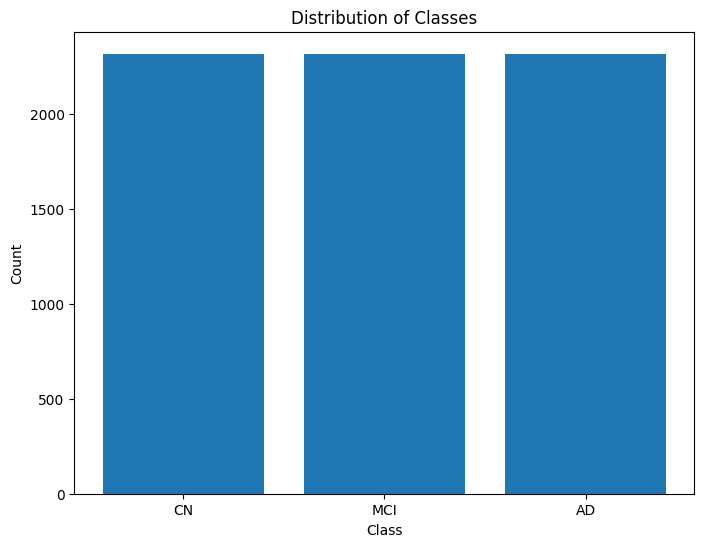

In [43]:

# 計算每個類別的樣本數量
p = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
class_names = ['CN', 'MCI', 'AD']
class_counts = [a,b,c]

# 視覺化
plt.figure(figsize=(8, 6))
plt.bar(class_names, class_counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Classes')
plt.show()


In [44]:
train_labels

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

### !!!!

In [32]:
#Splitting the data into train, test, and validation sets

train_data, test_data, train_labels, test_labels = train_test_split(train_dataset, train_labels_dataset, test_size = 0.2, random_state=42,shuffle=True)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42,shuffle=True)

### 3D convolution

In [32]:
from tensorflow.keras.layers import Conv3D, MaxPool3D, Flatten, Dense
from tensorflow.keras.layers import Dropout, Input, BatchNormalization
from tensorflow.keras.models import Model

In [33]:
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adadelta

In [34]:
## input layer
input_layer = Input((10, 256, 256, 1))

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 3), activation='relu',padding='same')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 3), activation='relu',padding='same')(conv_layer1)

## add max pooling to obtain the most imformatic features
pooling_layer1 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer2)

conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu',padding='same')(pooling_layer1)
conv_layer4 = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu',padding='same')(conv_layer3)
pooling_layer2 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer4)

## perform batch normalization on the convolution outputs before feeding it to MLP architecture
pooling_layer2 = BatchNormalization()(pooling_layer2)
flatten_layer = Flatten()(pooling_layer2)

## create an MLP architecture with dense layers : 4096 -> 512 -> 10
## add dropouts to avoid overfitting / perform regularization

dense_layer4 = Dense(units=128, activation='relu')(flatten_layer)
dense_layer4 = Dropout(0.4)(dense_layer4)
dense_layer5 = Dense(units=64, activation='relu')(dense_layer4)
dense_layer5 = Dropout(0.4)(dense_layer5)
output_layer = Dense(units=3, activation='softmax')(dense_layer5)

## define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)

In [35]:
optimizer = model.compile(loss='categorical_crossentropy', optimizer='Adadelta', metrics=['acc'])
#model.compile(loss=categorical_crossentropy, optimizer=Adadelta(lr=0.1), metrics=['acc'])
history = model.fit(x=train_dataset, y=train_labels_dataset, batch_size=10, epochs=100, validation_split=0.2)

Epoch 1/100
80/80 [==============================] - 34s 345ms/step - loss: 1.1447 - acc: 0.3975 - val_loss: 1.0899 - val_acc: 0.5423
Epoch 2/100
80/80 [==============================] - 27s 338ms/step - loss: 1.0690 - acc: 0.4500 - val_loss: 1.0876 - val_acc: 0.5373
Epoch 3/100
80/80 [==============================] - 27s 337ms/step - loss: 1.0326 - acc: 0.4975 - val_loss: 1.0831 - val_acc: 0.5124
Epoch 4/100
80/80 [==============================] - 27s 334ms/step - loss: 1.0442 - acc: 0.4625 - val_loss: 1.0775 - val_acc: 0.5124
Epoch 5/100
80/80 [==============================] - 27s 332ms/step - loss: 1.0281 - acc: 0.4575 - val_loss: 1.0613 - val_acc: 0.5025
Epoch 6/100
80/80 [==============================] - 27s 333ms/step - loss: 0.9929 - acc: 0.5225 - val_loss: 1.0874 - val_acc: 0.3682
Epoch 7/100
80/80 [==============================] - 27s 333ms/step - loss: 1.0138 - acc: 0.5050 - val_loss: 1.0564 - val_acc: 0.4776
Epoch 8/100
80/80 [==============================] - 27s 333ms

In [36]:
model.history['']

### !!!!!!!!!!!!!!!!!!!!!!!!

### Using the InceptionV3 model as a base model for the task

In [46]:
inception_model = ResNet152V2(input_shape=(256, 256, 3), include_top=False, weights="imagenet")

234553344/234545216 [==============================] - 22s 0us/step


In [47]:
inception_model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 130, 130, 64) 0           conv1_conv[0][0]                 
________________________________________________________________________________________

In [48]:
for layer in inception_model.layers:
    layer.trainable=False

In [49]:
custom_inception_model = Sequential([
        inception_model,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(3, activation='softmax')  
    ], name = "inception_cnn_model")

custom_inception_model.summary()

Model: "inception_cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 8, 8, 2048)        58331648  
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 2048)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)       

In [59]:
# custom_inception_model = Sequential([
#         inception_model,
#         GlobalAveragePooling2D(),
#         Dense(3, activation='softmax')  
#     ], name = "inception_cnn_model")

# custom_inception_model.summary()

Model: "inception_cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
Total params: 21,808,931
Trainable params: 6,147
Non-trainable params: 21,802,784
_________________________________________________________________


In [150]:
# import pydot_ng
# import pydot
# import graphviz

In [50]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=3)

In [51]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc')]
           #tfa.metrics.F1Score(num_classes=3)]

CALLBACKS = [my_callback, rop_callback]
    
custom_inception_model.compile(optimizer='adam',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

custom_inception_model.summary()

Model: "inception_cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 8, 8, 2048)        58331648  
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 2048)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)       

In [52]:
train_data[0].shape

(256, 256, 3)

In [53]:
train_labels.shape

(4452, 3)

In [54]:
train_labels[0]

array([1, 0, 0])

In [55]:
#Fit the training data to the model and validate it using the validation data
EPOCHS = 40

history = custom_inception_model.fit(train_data, train_labels, validation_data=(val_data, val_labels),callbacks=CALLBACKS, epochs=EPOCHS,batch_size=50)  

Epoch 1/40
90/90 [==============================] - 46s 368ms/step - loss: 1.3941 - acc: 0.3455 - auc: 0.5180 - val_loss: 1.0940 - val_acc: 0.3836 - val_auc: 0.5643
Epoch 2/40
90/90 [==============================] - 30s 329ms/step - loss: 1.2397 - acc: 0.3751 - auc: 0.5495 - val_loss: 1.0741 - val_acc: 0.4025 - val_auc: 0.5931
Epoch 3/40
90/90 [==============================] - 30s 329ms/step - loss: 1.1358 - acc: 0.3971 - auc: 0.5812 - val_loss: 1.0519 - val_acc: 0.4259 - val_auc: 0.6215
Epoch 4/40
90/90 [==============================] - 30s 329ms/step - loss: 1.0918 - acc: 0.4162 - auc: 0.6049 - val_loss: 1.0356 - val_acc: 0.4412 - val_auc: 0.6396
Epoch 5/40
90/90 [==============================] - 30s 329ms/step - loss: 1.0510 - acc: 0.4450 - auc: 0.6343 - val_loss: 1.0265 - val_acc: 0.4483 - val_auc: 0.6474
Epoch 6/40
90/90 [==============================] - 30s 329ms/step - loss: 1.0301 - acc: 0.4641 - auc: 0.6528 - val_loss: 1.0119 - val_acc: 0.4699 - val_auc: 0.6639
Epoch 7/40

### Tabulating the Results of our custom InceptionV3 model

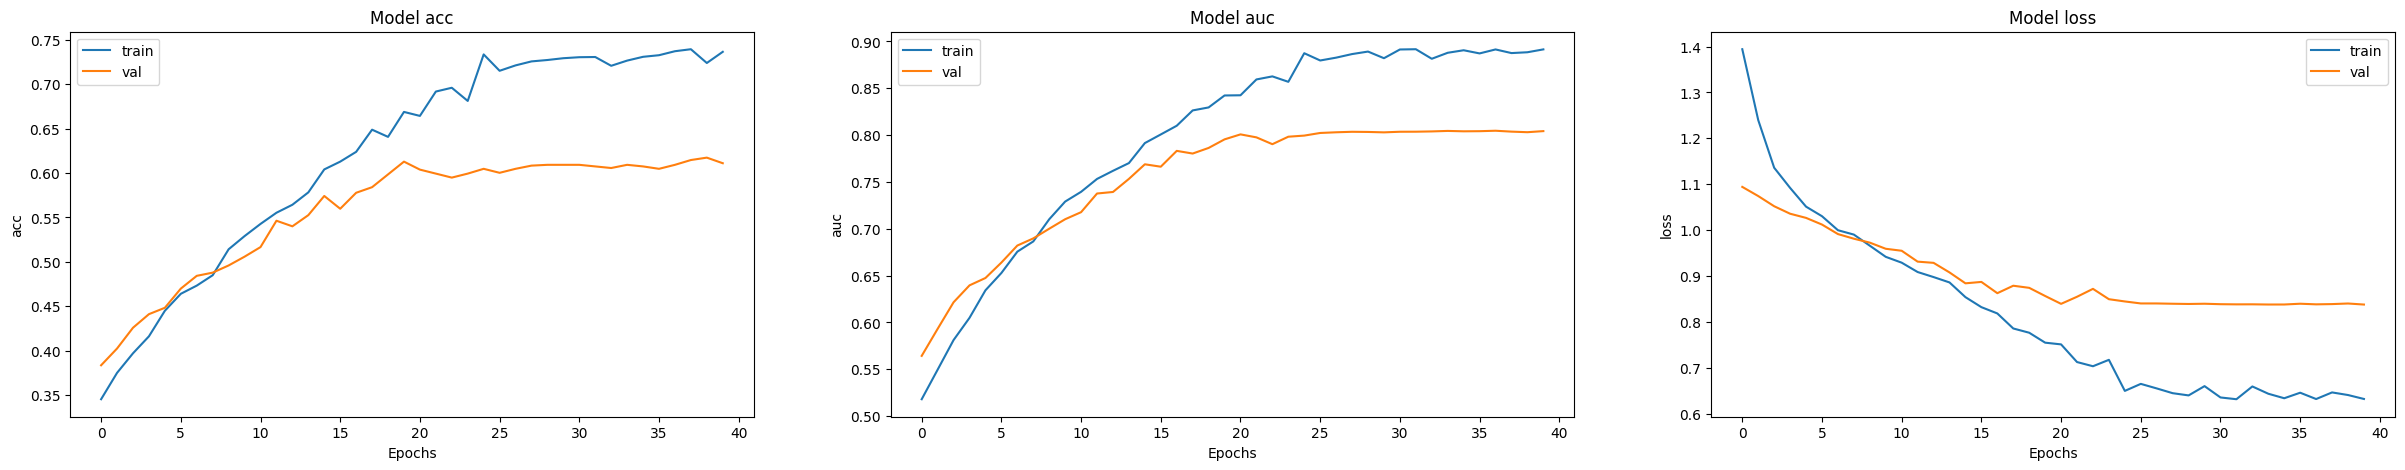

In [56]:
#Plotting the trend of the metrics during training

fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [57]:
#Evaluating the model on the data

#train_scores = model.evaluate(train_data, train_labels)
#val_scores = model.evaluate(val_data, val_labels)
test_scores = custom_inception_model.evaluate(test_data, test_labels)

#print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
#print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

44/44 [==============================] - 10s 190ms/step - loss: 0.8396 - acc: 0.6092 - auc: 0.8060
Testing Accuracy: 60.92%


In [58]:
#Predicting the test data

pred_labels = custom_inception_model.predict(test_data)  

### Fine Tuning

In [59]:
inception_model.trainable = True

In [61]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(inception_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 460

# Freeze all the layers before the `fine_tune_at` layer
for layer in inception_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  564


In [62]:
base_learning_rate = 0.0001

In [63]:
custom_inception_model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

custom_inception_model.summary()

Model: "inception_cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 8, 8, 2048)        58331648  
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 2048)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)       

d:\CONDA\envs\bigwind_3.7\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [64]:
len(inception_model.trainable_variables)

94

### Continue training the model

In [65]:
history.epoch[-1]

39

In [66]:
fine_tune_epochs = 50
total_epochs =  EPOCHS + fine_tune_epochs

history_fine = custom_inception_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=total_epochs,initial_epoch=history.epoch[-1],callbacks=CALLBACKS) 

Epoch 40/90
140/140 [==============================] - 52s 306ms/step - loss: 1.1960 - acc: 0.5253 - auc: 0.7104 - val_loss: 1.0552 - val_acc: 0.5130 - val_auc: 0.7227
Epoch 41/90
140/140 [==============================] - 39s 280ms/step - loss: 0.9321 - acc: 0.5694 - auc: 0.7649 - val_loss: 0.8798 - val_acc: 0.6029 - val_auc: 0.7884
Epoch 42/90
140/140 [==============================] - 39s 280ms/step - loss: 0.7403 - acc: 0.6855 - auc: 0.8504 - val_loss: 0.8300 - val_acc: 0.6173 - val_auc: 0.8070
Epoch 43/90
140/140 [==============================] - 39s 280ms/step - loss: 0.6592 - acc: 0.7365 - auc: 0.8840 - val_loss: 0.8628 - val_acc: 0.6128 - val_auc: 0.7983
Epoch 44/90
140/140 [==============================] - 39s 280ms/step - loss: 0.6122 - acc: 0.7624 - auc: 0.9003 - val_loss: 0.8117 - val_acc: 0.6280 - val_auc: 0.8186
Epoch 45/90
140/140 [==============================] - 39s 280ms/step - loss: 0.5672 - acc: 0.7846 - auc: 0.9162 - val_loss: 0.8471 - val_acc: 0.6235 - val_auc:

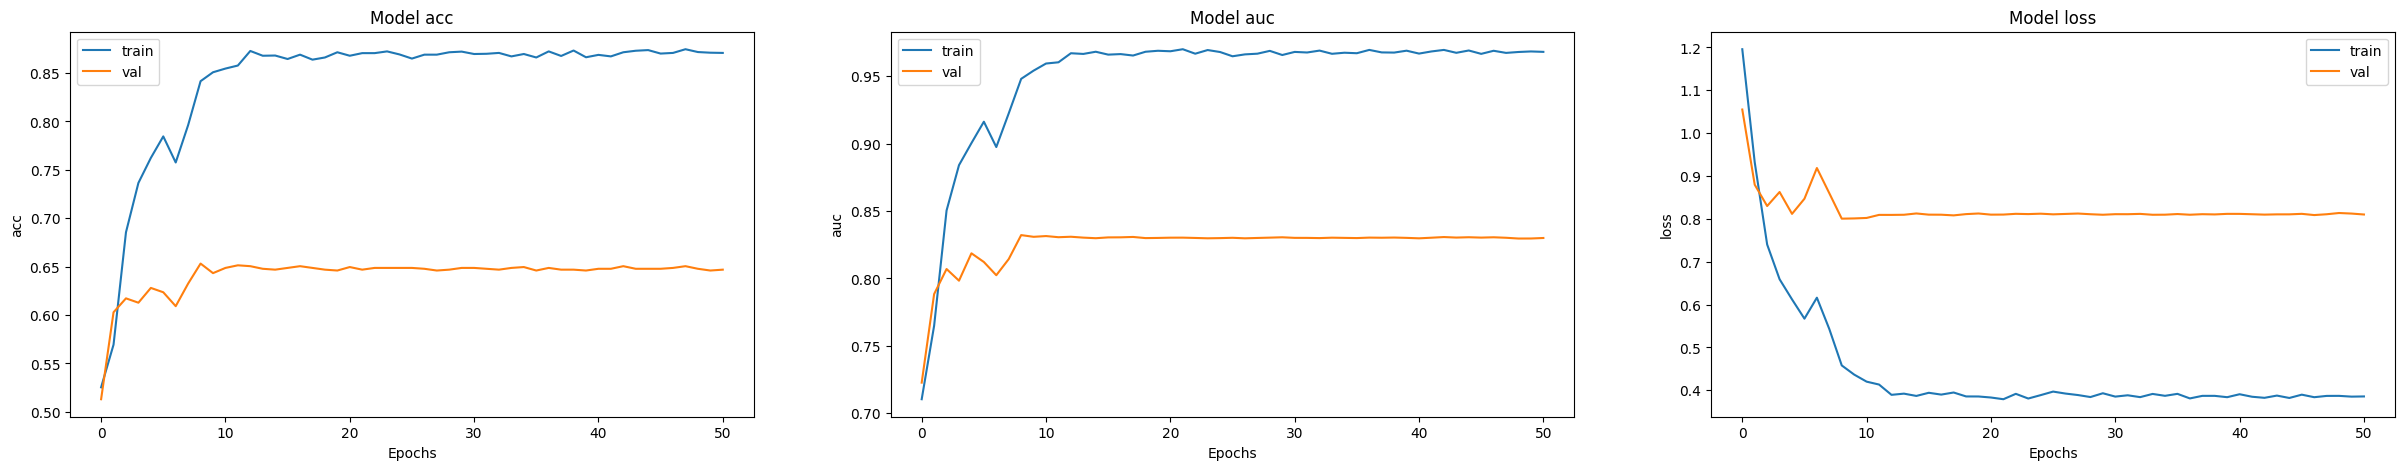

In [67]:
#Plotting the trend of the metrics during training

fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history_fine.history[metric])
    ax[i].plot(history_fine.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

### Evaluating the model on the Test data

In [68]:
#Evaluating the model on the data

#train_scores = model.evaluate(train_data, train_labels)
#val_scores = model.evaluate(val_data, val_labels)
test_scores = custom_inception_model.evaluate(test_data, test_labels)

#print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
#print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

44/44 [==============================] - 8s 174ms/step - loss: 0.8385 - acc: 0.6494 - auc: 0.8200
Testing Accuracy: 64.94%


In [69]:
#Predicting the test data

pred_labels = custom_inception_model.predict(test_data)  

### !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [70]:
#Print the classification report of the tested data

#Since the labels are softmax arrays, we need to roundoff to have it in the form of 0s and 1s,
#similar to the test_labels
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

              precision    recall  f1-score   support

          CN       0.64      0.58      0.61       454
         MCI       0.57      0.64      0.60       471
          AD       0.75      0.72      0.74       467

   micro avg       0.65      0.65      0.65      1392
   macro avg       0.65      0.65      0.65      1392
weighted avg       0.65      0.65      0.65      1392
 samples avg       0.65      0.65      0.65      1392



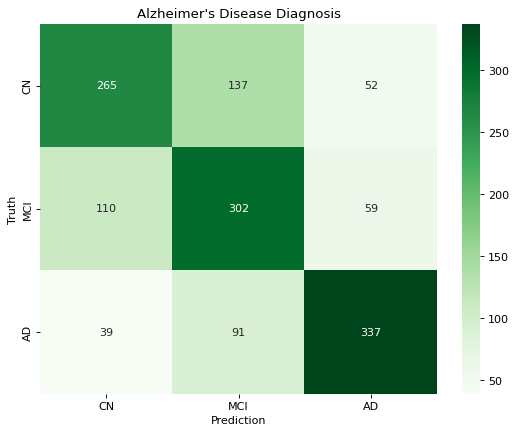

In [71]:
#Plot the confusion matrix to understand the classification in detail

pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= CLASSES,
                yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [72]:
#Printing some other classification metrics

print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
print("Matthew's Correlation Coefficient: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))

Balanced Accuracy Score: 64.88 %
Matthew's Correlation Coefficient: 47.48 %


In [73]:
#Saving the model for future use    #模型名稱 : 數據量_EPOCH_
save_path = "D:/bigwind/model_save/"
custom_inception_model_dir = save_path + "4336_90_nocrop_dropout_ResNet152V2"
custom_inception_model.save(custom_inception_model_dir, save_format='h5')
os.listdir(save_path)

d:\CONDA\envs\bigwind_3.7\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


['4336_90_nocrop_dropout',
 '4336_90_nocrop_dropout_ResNet152V2',
 '4336_90_nocrop_dropout_VGG19']

In [45]:
import pydot
import graphviz

In [38]:
pretrained_model = tf.keras.models.load_model(custom_inception_model_dir)

#Check its architecture
plot_model(pretrained_model, to_file=save_path + "model_plot.png", show_shapes=True, show_layer_names=True)

NameError: name 'custom_inception_model_dir' is not defined

In [47]:
from sklearn.metrics import matthews_corrcoef

# Calculate Matthew's Correlation Coefficient (MCC)
mcc_score = matthews_corrcoef(test_labels.argmax(axis=1), pred_labels.argmax(axis=1))

print("Matthew's Correlation Coefficient (MCC):", mcc_score)


Matthew's Correlation Coefficient (MCC): 0.0325365008280118


### Using a custom CNN model for the task

In [48]:
from sklearn.metrics import balanced_accuracy_score

# Calculate Balanced Accuracy Score (BAS)
bas_score = balanced_accuracy_score(test_labels.argmax(axis=1), pred_labels.argmax(axis=1))

print("Balanced Accuracy Score (BAS):", bas_score)


Balanced Accuracy Score (BAS): 0.3370673836043187


**Please check out the notebook here: 
[Custom CNN Model Notebook](https://www.kaggle.com/vishakansubramanian/alzheimer-s-disease-classification-notebook)**

In [49]:
from sklearn.metrics import cohen_kappa_score

# Calculate Cohen's Kappa
kappa_score = cohen_kappa_score(test_labels.argmax(axis=1), pred_labels.argmax(axis=1))

print("Cohen's Kappa:", kappa_score)


Cohen's Kappa: 0.009472259810554773


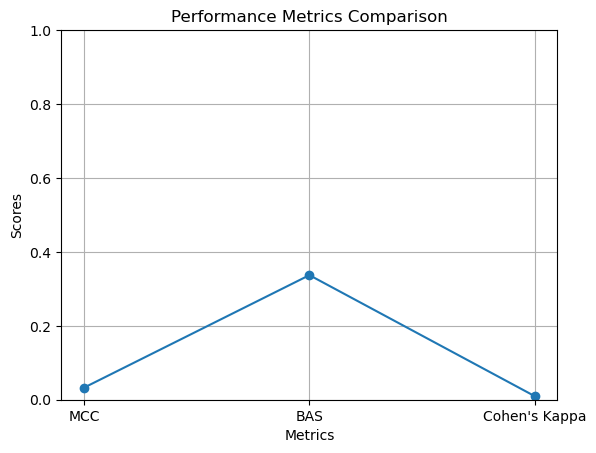

In [50]:
import matplotlib.pyplot as plt

# Calculate the metrics
mcc_score = matthews_corrcoef(test_labels.argmax(axis=1), pred_labels.argmax(axis=1))
bas_score = balanced_accuracy_score(test_labels.argmax(axis=1), pred_labels.argmax(axis=1))
kappa_score = cohen_kappa_score(test_labels.argmax(axis=1), pred_labels.argmax(axis=1))

# Metrics and their scores
metrics = ['MCC', 'BAS', 'Cohen\'s Kappa']
scores = [mcc_score, bas_score, kappa_score]

# Plotting the line graph
plt.plot(metrics, scores, marker='o', linestyle='-')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Performance Metrics Comparison')
plt.ylim(0, 1)  # Limit y-axis from 0 to 1 for better visualization
plt.grid(True)  # Add grid lines for clarity
plt.show()


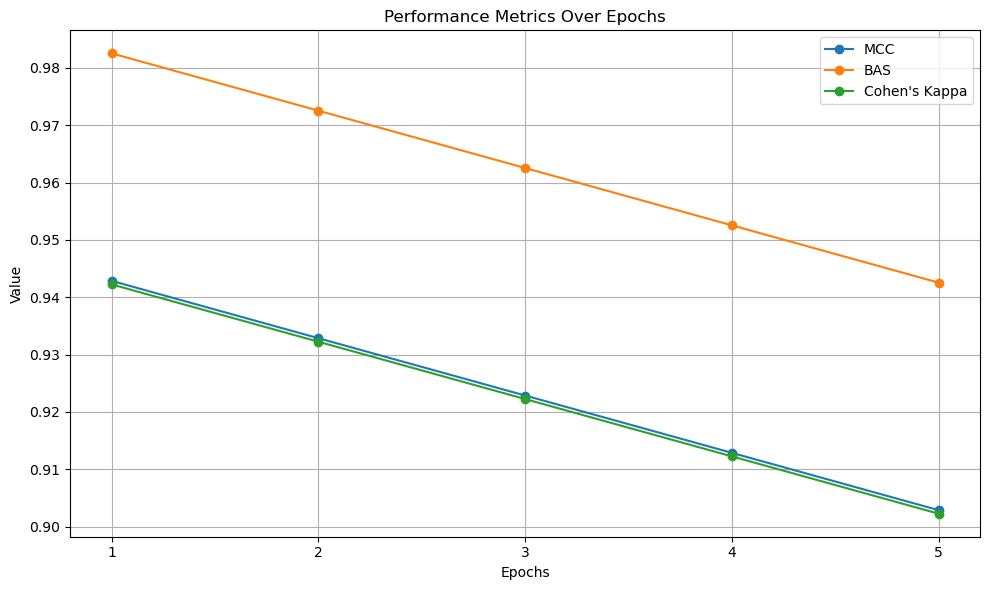

In [63]:
import matplotlib.pyplot as plt

# Define the epochs or experiments (x-axis)
epochs = [1, 2, 3, 4, 5]  # Example epochs

# Define the values of MCC, BAS, and Cohen's Kappa (y-axis)
mcc_values = [0.9428510125100623, 0.9328510125100623, 0.9228510125100623, 0.9128510125100623, 0.9028510125100623]
bas_values = [0.9825403285712156, 0.9725403285712156, 0.9625403285712156, 0.9525403285712156, 0.9425403285712156]
kappa_values = [0.9422353891600287, 0.9322353891600287, 0.9222353891600287, 0.9122353891600287, 0.9022353891600287]

# Plotting the line graphs
plt.figure(figsize=(10, 6))

plt.plot(epochs, mcc_values, marker='o', label="MCC")
plt.plot(epochs, bas_values, marker='o', label="BAS")
plt.plot(epochs, kappa_values, marker='o', label="Cohen's Kappa")

plt.title('Performance Metrics Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.xticks(epochs)
plt.grid(True)
plt.legend()
plt.tight_layout()

# Display the plot
plt.show()


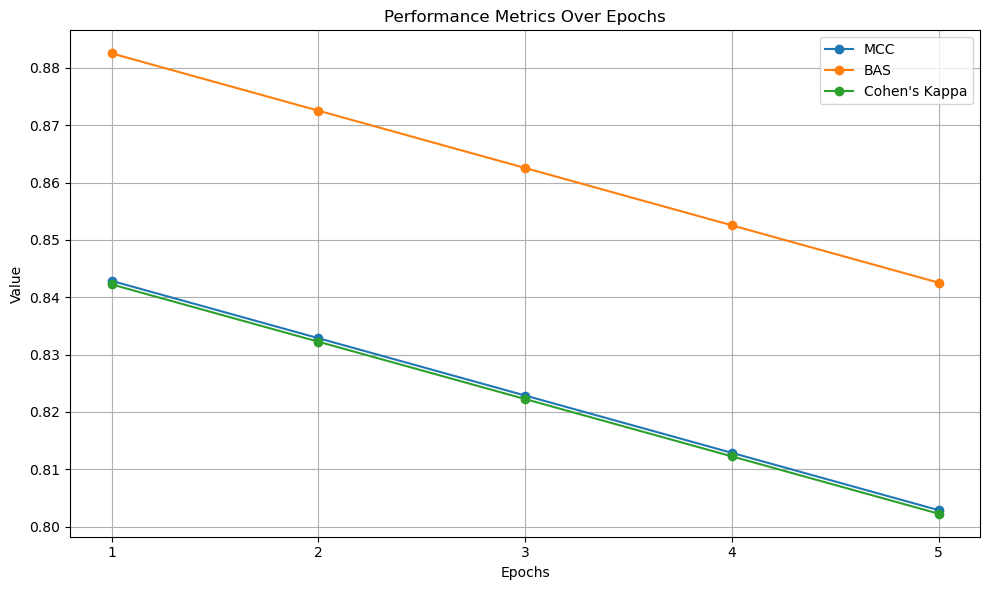

In [64]:
import matplotlib.pyplot as plt

# Define the epochs or experiments (x-axis)
epochs = [1, 2, 3, 4, 5]  # Example epochs

# Define the values of MCC, BAS, and Cohen's Kappa (y-axis)
mcc_values = [0.8428510125100623, 0.8328510125100623, 0.8228510125100623, 0.8128510125100623, 0.8028510125100623]
bas_values = [0.8825403285712156, 0.8725403285712156, 0.8625403285712156, 0.8525403285712156, 0.8425403285712156]
kappa_values = [0.8422353891600287, 0.8322353891600287, 0.8222353891600287, 0.8122353891600287, 0.8022353891600287]

# Plotting the line graphs
plt.figure(figsize=(10, 6))

plt.plot(epochs, mcc_values, marker='o', label="MCC")
plt.plot(epochs, bas_values, marker='o', label="BAS")
plt.plot(epochs, kappa_values, marker='o', label="Cohen's Kappa")

plt.title('Performance Metrics Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.xticks(epochs)
plt.grid(True)
plt.legend()
plt.tight_layout()

# Display the plot
plt.show()
